# ISPR 2025 - Midterm 2 - Assignament 3 - Gianluca Panzani (550358)

## Load the MNIST dataset
The dataset contains flattened grayscale images of handwritten digits. In the following part of the code, the images are loaded and normalized from values in range [0,255] to range [0,1].

In [90]:
import numpy as np
import struct

def load_images(filename):
    with open(filename, 'rb') as f:
        magic, num, rows, cols = struct.unpack('>IIII', f.read(16))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        data = data.reshape(num, rows * cols)
        return data / 255.0
    
def load_labels(filename):
    with open(filename, 'rb') as f:
        magic, num = struct.unpack('>II', f.read(8))
        data = np.frombuffer(f.read(), dtype=np.uint8)
        return data

X_train = load_images('mnist/train-images.idx3-ubyte')
y_train = load_labels('mnist/train-labels.idx1-ubyte')

X_test = load_images('mnist/t10k-images.idx3-ubyte')
y_test = load_labels('mnist/t10k-labels.idx1-ubyte')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000,)
(10000,)


## Restricted Boltzmann Machine: class definition
In this block is defined the RBM class. The methods are described into the documentation.

In [91]:
class RBM:
    '''
    Restricted Boltzmann Machine (RBM) implementation: a generative stochastic neural network 
    that can learn a probability distribution over its set of inputs.

    Attributes:
        - n_visible (int): number of visible units (input features).
        - n_hidden (int): number of hidden units (latent features).
        - M (np.ndarray): weight matrix of shape (n_visible, n_hidden), initialized randomly.
        - b (np.ndarray): bias vector for visible units of shape (n_visible).
        - c (np.ndarray): bias vector for hidden units of shape (n_hidden).
    '''
    def __init__(self, n_visible, n_hidden):
        self.n_visible = n_visible
        self.n_hidden = n_hidden

        # Weights initialization (generated randomly samples from a normal Gaussian distribution)
        self.M = np.random.normal(0, 0.01, size=(n_visible, n_hidden))

        # Bias initialization (initially zeros) for visible and hidden layers respectively
        self.b = np.zeros(n_visible)
        self.c = np.zeros(n_hidden)

    def sigmoid(self, x: np.ndarray):
        '''
        Formula of the sigmoid activation function, defined as: 1 / (1 + exp(-x)), which maps any real
        number to the (0, 1) interval of probability.

        Params:
            - x (np.ndarray): input array.

        Returns:
            - np.ndarray: output array with the sigmoid function applied element-wise.
        '''
        return 1.0 / (1.0 + np.exp(-x))

    def sample_prob(self, probs):
        '''
        Samples binary activations based on given probabilities. For each element in the input array,
        a random number is generated and compared to the probability. If the random number is less than
        the probability the output is 1, otherwise it's 0.

        Params:
            - probs (np.ndarray): array of probabilities.

        Returns:
            - np.ndarray: binary (0 or 1) sampled activations.
        '''
        return (np.random.rand(*probs.shape) < probs).astype(np.float32)
    
    def v_to_h(self, v: np.ndarray):
        '''
        Performs a forward pass from the visible layer to the hidden layer. Computes the activation
        probabilities of the hidden units given the visible input and then samples binary activations.

        Params:
            - v (np.ndarray): binary input array representing the state of the visible units.

        Returns:
            - h_prob (np.ndarray): probabilities of the hidden units being activated.
            - h_sample (np.ndarray): sampled binary states of the hidden units.
        '''
        h_prob = self.sigmoid(np.dot(v, self.M) + self.c) # sigma(vW + c)
        h_sample = self.sample_prob(h_prob)
        return h_prob, h_sample

    def h_to_v(self, h: np.ndarray):
        '''
        Performs a backward pass from the hidden layer to the visible layer. Computes the activation
        probabilities of the visible units given the hidden input and then samples binary reconstructions.

        Params:
            - h (np.ndarray): Binary input array representing the state of the hidden units.

        Returns:
            - v_prob (np.ndarray): Probabilities of the visible units being activated.
            - v_sample (np.ndarray): Sampled binary states of the visible units.
        '''
        v_prob = self.sigmoid(np.dot(h, self.M.T) + self.b) # sigma(hM^T + b)
        v_sample = self.sample_prob(v_prob)
        return v_prob, v_sample
    
    def contrastive_divergence(self, v0: np.ndarray, lr: float = 0.1, k: int = 1):
        '''
        Performs Contrastive Divergence (CD-k) to update the model's weights and biases. CD approximates the
        gradient of the log-likelihood by comparing real data with reconstructions.

        Params:
            - v0 (np.ndarray): a single batch of visible units (from the input data).
            - lr (float): learning rate for weight and bias updates.
            - k (int): number of Gibbs sampling steps.

        Returns:
            - loss (float): mean squared reconstruction error on the batch.
        '''

        # Positive phase
        h0_prob, h0_sample = self.v_to_h(v0)
        # Gibbs sampling (k full steps)
        vk_sample = v0
        hk_sample = h0_sample
        for i in range(k):
            vk_prob, vk_sample = self.h_to_v(hk_sample) # visible <- hidden
            hk_prob, hk_sample = self.v_to_h(vk_sample) # visible -> hidden
        vk = vk_sample
        hk = hk_sample

        # Negative phase
        # Gradient computed on real data (and real probability distribution)
        positive_grad = np.dot(v0.T, h0_prob) # v0^T h0
        # Gradient computed on sampled data (and sampled probability distribution)
        negative_grad = np.dot(vk.T, hk_prob) # vk^T hk

        # Update of Weights matrix and Bias vectors
        batch_size = v0.shape[0]
        self.M += lr * (positive_grad - negative_grad) / batch_size
        self.b += lr * np.mean(v0 - vk, axis=0)
        self.c += lr * np.mean(h0_prob - hk_prob, axis=0)

        # Return the loss between the real visible data and the sampled one after k steps of Gibbs sampling
        return np.mean((v0 - vk) ** 2)


## Training of two RBMs with different values of k
This section trains two Restricted Boltzmann Machines (RBMs) with the same architecture (784 visible units and 64 hidden units) but different values of k for the Contrastive Divergence (CD) algorithm. Specifically, RBM1 is trained using CD-1 (k=1), while RBM2 uses CD-10 (k=10).

The training is performed over 10 epochs using mini-batches of size 64 and a learning rate of 0.1. For each epoch, the model computes the average loss, with Mean Squared Error (MSE), across all batches and stores it for later analysis.

The goal of this training is to compare how different values of k affect the learning process and the quality of the representations learned by the RBMs.

In [92]:
# Create the Restricted Boltzmann Machine object (with 784 visible units and 64 hidden units)
rbm1 = RBM(784,128)
rbm2 = RBM(784,128)

# Parameters initializations
n_epochs = 10
batch_size = 128
lr = 0.1
k1 = 1
k2 = 10
n_batches = X_train.shape[0] // batch_size

# Batch iterations
losses1 = []
losses2 = []
for epoch in range(n_epochs):
    sum_loss1 = sum_loss2 = 0
    for i in range(0, X_train.shape[0], batch_size):
        v0 = X_train[i:i + batch_size]
        loss1 = rbm1.contrastive_divergence(v0, lr=lr, k=k1)
        loss2 = rbm2.contrastive_divergence(v0, lr=lr, k=k2)
        sum_loss1 += loss1
        sum_loss2 += loss2
    avg_loss1 = sum_loss1 / n_batches
    avg_loss2 = sum_loss2 / n_batches
    losses1.append(avg_loss1)
    losses2.append(avg_loss2)
    print(f'Epoch {epoch+1}/{n_epochs} - Loss 1: {avg_loss1:.4f} - Loss 2: {avg_loss2:.4f}')


Epoch 1/10 - Loss 1: 0.1083 - Loss 2: 0.1499
Epoch 2/10 - Loss 1: 0.0752 - Loss 2: 0.1031
Epoch 3/10 - Loss 1: 0.0672 - Loss 2: 0.0944
Epoch 4/10 - Loss 1: 0.0629 - Loss 2: 0.0897
Epoch 5/10 - Loss 1: 0.0600 - Loss 2: 0.0865
Epoch 6/10 - Loss 1: 0.0579 - Loss 2: 0.0842
Epoch 7/10 - Loss 1: 0.0563 - Loss 2: 0.0823
Epoch 8/10 - Loss 1: 0.0549 - Loss 2: 0.0807
Epoch 9/10 - Loss 1: 0.0538 - Loss 2: 0.0794
Epoch 10/10 - Loss 1: 0.0528 - Loss 2: 0.0783


## Comparison between the loss functions
This plot shows the loss functions over 10 training epochs for two RBMs trained with different values of k in the Contrastive Divergence algorithm.

RBM (k=1) converges faster and reaches a lower reconstruction loss compared to RBM (k=10). This indicates that, in this setting, using a small number of Gibbs sampling steps (k=1) leads to better and more efficient learning. On the other hand, the RBM trained with k=10 starts with a significantly higher loss and improves more slowly.

This result is consistent with known behavior of Contrastive Divergence, where small values of k can provide better empirical results.


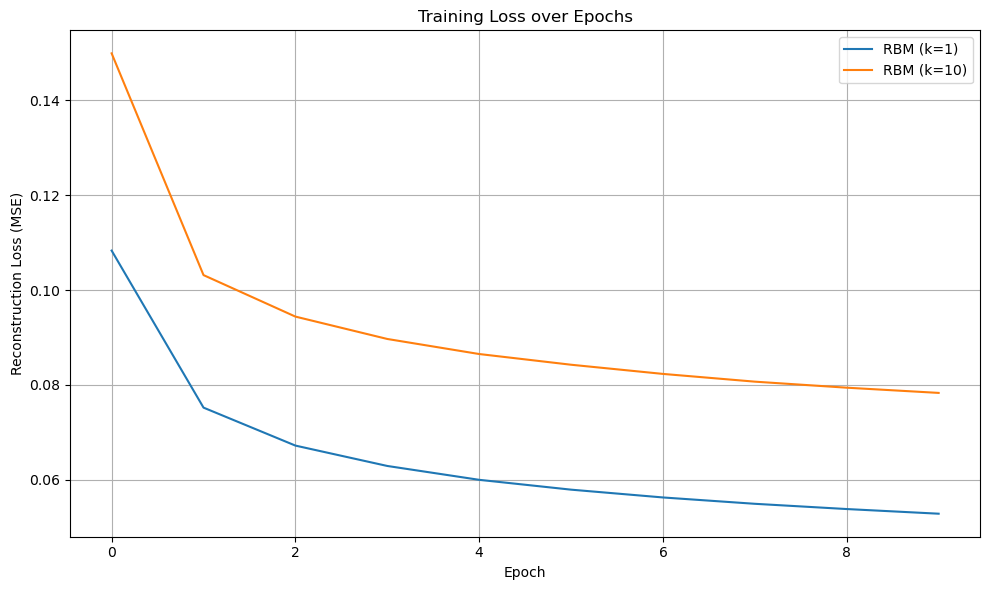

In [93]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(losses1, label=f'RBM (k={k1})')
plt.plot(losses2, label=f'RBM (k={k2})')
plt.xlabel('Epoch')
plt.ylabel('Reconstruction Loss (MSE)')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Classification task
After training the RBMs with k=1 and k=10, the hidden layer activations were used as feature representations to train two separate Logistic Regression classifiers. The goal was to evaluate the learned representations for the digit classification task.

The classifier trained on the features from RBM1 (k=1) achieved an accuracy of 91.61% on the test set, while the classifier using features from RBM2 (k=10) reached 89.89%.

The difference is small, but RBM1 outperformed RBM2 in terms of reconstruction loss and classification accuracy. This result suggests that a smaller number of Gibbs sampling steps (k=1) is not only more computationally efficient but also sufficient to produce meaningful feature representations in this context.

This confirm what is commonly observed in literature: CD-1 often works surprisingly well with simple classification tasks.

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Encode training set with both RBMs
_, H_train_1 = rbm1.v_to_h(X_train)
_, H_test_1 = rbm1.v_to_h(X_test)
_, H_train_2 = rbm2.v_to_h(X_train)
_, H_test_2 = rbm2.v_to_h(X_test)

# Training of classifiers
clf1 = LogisticRegression(max_iter=1000)
clf2 = LogisticRegression(max_iter=1000)
clf1.fit(H_train_1, y_train)
clf2.fit(H_train_2, y_train)

# Predictions on test sets
y_pred_1 = clf1.predict(H_test_1)
y_pred_2 = clf2.predict(H_test_2)

# Compute the accuracy
acc1 = accuracy_score(y_test, y_pred_1)
acc2 = accuracy_score(y_test, y_pred_2)

print(f'Accuracy with RBM1 (k={k1}): {acc1:.4f}')
print(f'Accuracy with RBM2 (k={k2}): {acc2:.4f}')

Accuracy with RBM1 (k=1): 0.9203
Accuracy with RBM2 (k=10): 0.9192


/Users/gianlucapanzani/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Reconstruction
The following figure compares the reconstruction quality of three MNIST digits using two RBMs.

For each digit (7, 2, 1), the original image is shown on the left, followed by the reconstructions produced by RBM1 (k=1) and RBM2 (k=10), respectively.

Visually, both RBMs are able to capture the general structure of the digits, but RBM1 (k=1) tends to produce slightly more accurate reconstructions. RBM2 (k=10), although capable of capturing the general digit shape, shows more blurring and noise in some parts of the images.

These qualitative results align with the quantitative metrics: RBM1 achieved both lower reconstruction loss and higher classification accuracy, confirming that even a small number of Gibbs sampling steps (k=1) is sufficient for effective feature learning in this case.

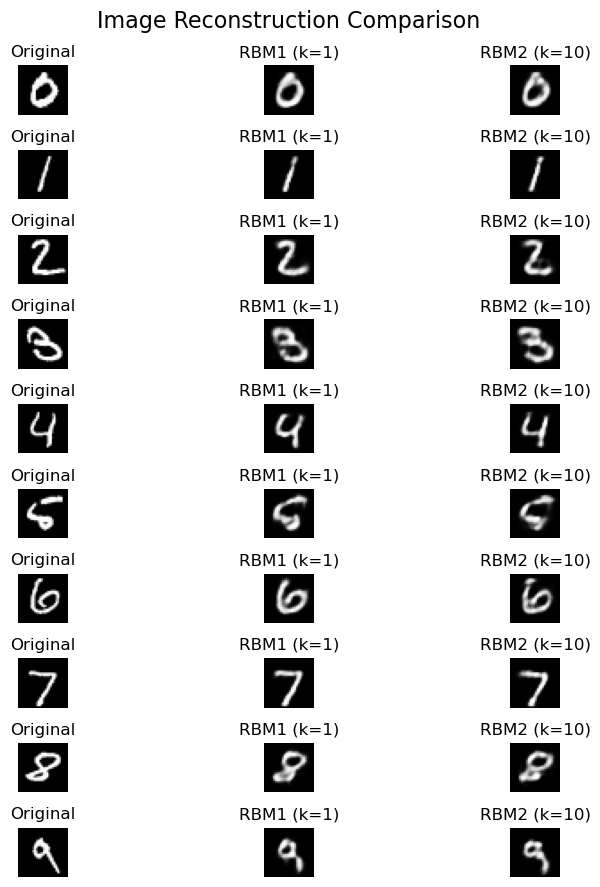

In [95]:
# Pick the first sample for each different digit
samples = np.array([X_test[y_test == digit][0] for digit in list(range(10))])

# Reconstruction with both RBMs
_, h1 = rbm1.v_to_h(samples)
_, h2 = rbm2.v_to_h(samples)
v1_recon_prob, _ = rbm1.h_to_v(h1)
v2_recon_prob, _ = rbm2.h_to_v(h2)

# Plot of the reconstructed images
fig, axes = plt.subplots(10, 3, figsize=(9, 9))
for i in range(10):

    # Original
    axes[i, 0].imshow(samples[i].reshape(28, 28), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')

    # RBM1
    axes[i, 1].imshow(v1_recon_prob[i].reshape(28, 28), cmap='gray')
    axes[i, 1].set_title(f'RBM1 (k={k1})')
    axes[i, 1].axis('off')

    # RBM2
    axes[i, 2].imshow(v2_recon_prob[i].reshape(28, 28), cmap='gray')
    axes[i, 2].set_title(f'RBM2 (k={k2})')
    axes[i, 2].axis('off')

plt.suptitle('Image Reconstruction Comparison', fontsize=16)
plt.tight_layout()
plt.show()